In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
from dataio.genetics import GeneticDataset, GeneticOneHot
import pandas as pd
import torch
from model.utils import decode_onehot
import matplotlib.pyplot as plt
from model.ppnet import PPNet

In [78]:
TRAIN_PATH = "datasets/genetics/small_diptera_family-train.tsv"
# TRAIN_PATH = "data/BIOSCAN-1M/small_order_train.tsv"
VALIDATION_PATH = "datasets/genetics/small_diptera_family-validation.tsv"
TAXONOMY_NAME = "genus"
# PROTOTYPE_PATH = "saved_models/genetics/prototype_saving_test_images/epoch-80/genetic-string.csv"
PROTOTYPE_PATH = "saved_models/genetics/prototype_saving_test_images/real_run/epoch-80/genetic-string.csv"
WEIGHT_PATH = "saved_models/genetics/prototype_saving_test_images/real_run/80_push_weights.pth"
PROTOTYPE_COUNT = 10
CLASS_COUNT = 40

In [98]:
ppnet = torch.load(WEIGHT_PATH)

OrderedDict([('weight', tensor([[ 1.5116e+00,  1.4286e+00,  1.1680e+00,  ..., -2.3224e-01,
         -1.8759e-01, -1.8753e-01],
        [-4.2280e-04, -4.0244e-04, -3.5393e-02,  ..., -2.8445e-01,
         -3.1507e-01, -3.1495e-01],
        [-1.5598e-02, -1.4252e-04, -2.0235e-04,  ..., -2.4069e-01,
         -2.8359e-01, -2.8350e-01],
        ...,
        [-1.2816e-05, -8.4790e-05, -9.6460e-05,  ..., -3.5222e-01,
         -3.9929e-01, -3.9910e-01],
        [-7.7459e-02,  2.4511e-04, -4.2826e-02,  ..., -3.1516e-01,
         -3.3165e-01, -3.3152e-01],
        [ 1.7044e-04, -4.5320e-05, -1.6786e-04,  ...,  7.5376e-01,
          7.4191e-01,  7.4191e-01]], device='cuda:0'))])


In [79]:
codon_map_a = {
    "Phe": ["TTT", "TTC"],
    "Leu": ["TTA", "TTG", "CTT", "CTC", "CTA", "CTG"],
    "Ile": ["ATT", "ATC", "ATA"],
    "Met": ["ATG"],
    "Val": ["GTT", "GTC", "GTA", "GTG"],
    "Ser": ["TCT", "TCC", "TCA", "TCG", "AGT", "AGC"],
    "Pro": ["CCT", "CCC", "CCA", "CCG"],
    "Thr": ["ACT", "ACC", "ACA", "ACG"],
    "Ala": ["GCT", "GCC", "GCA", "GCG"],
    "Tyr": ["TAT", "TAC"],
    "Stop": ["TAA", "TAG", "TGA"],
    "His": ["CAT", "CAC"],
    "Gln": ["CAA", "CAG"],
    "Asn": ["AAT", "AAC"],
    "Lys": ["AAA", "AAG"],
    "Asp": ["GAT", "GAC"],
    "Glu": ["GAA", "GAG"],
    "Cys": ["TGT", "TGC"],
    "Trp": ["TGG"],
    "Arg": ["CGT", "CGC", "CGA", "CGG", "AGA", "AGG"],
    "Gly": ["GGT", "GGC", "GGA", "GGG"],
    "None": ["NNN"],
}

codon_map = {}

for aa, codons in codon_map_a.items():
    for codon in codons:
        codon_map[codon] = aa

In [80]:
train_dataset = GeneticDataset(TRAIN_PATH,
                              "onehot", 
                              TAXONOMY_NAME,
                              max_class_count=CLASS_COUNT,
                              restraint=("family", ["Cecidomyiidae"]))

validation_dataset = validation_dataset = GeneticDataset(VALIDATION_PATH, 
                              "onehot",
                              TAXONOMY_NAME,
                              train_dataset.get_classes(TAXONOMY_NAME)[0])


In [81]:
prototype_df = pd.read_csv(PROTOTYPE_PATH)

In [82]:
prototype_df

,key,class_index,prototype_index,patch
0,0,0,0,ACATTGTATTTTATATTA
1,1,0,1,GAGCATGATCAGGTATAG
2,2,0,2,AGGAACTTCATTAAGAAT
3,3,0,3,CTTATTCGAGCTGAATTA
4,4,0,4,ATTAGGACATCCAGGAGC
...,...,...,...,...
1115,1595,39,35,TCCTATTTTATACCAACA
1116,1596,39,36,TTTATNNNNNNNNNNNNN
1117,1597,39,37,NNNNNNNNNNNNNNNNNN
1118,1598,39,38,NNNNNNNNNNNNNNNNNN


In [83]:
prot_strings = [["" for j in range(0,40)] for i in range(0, 40)]

for i in range(0, len(prototype_df)):
    class_index = prototype_df.iloc[i]["class_index"]
    prototype_index = prototype_df.iloc[i]["prototype_index"]
    string = prototype_df.iloc[i]["patch"]

    prot_strings[class_index][prototype_index] = string

full_strings = ["".join(string) for string in prot_strings]

In [84]:
encoder = GeneticOneHot(include_height_channel=True)
tensors = [encoder(s) if s != "" else None for s in full_strings]

In [85]:
input_tensor = validation_dataset[100]
input_tensor[1]

tensor(17)

In [86]:
print(input_tensor[0], tensors[0])

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 1.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.]]]) tensor([[[1., 0., 1.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])


In [87]:
def find_matching_dims(input_tensor, prototype_tensors, class_index):
    tensor = prototype_tensors[class_index]

    if tensor is None:
        print("No prototype tensor found for class index", class_index)
        return None
    
    if input_tensor.shape != tensor.shape:
        print("Shape mismatch for class index", class_index)
        return None
    
    output = torch.eq(input_tensor, tensor)
    # sum along the channel dimension
    output = output.sum(0)
    # integer divide by the number of channels
    output = output // 4
    return output[0]

In [88]:
find_matching_dims(input_tensor[0], tensors, 9)

tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,

In [89]:
# Open the weights
weights = torch.load(WEIGHT_PATH)["weight"]

class_weights = torch.zeros(CLASS_COUNT, 40)

# Reshape the weights
weights = weights.reshape(CLASS_COUNT, 40, 40)

for i in range(CLASS_COUNT):
    for j in range(40):
        class_weights[i][j] = weights[i][i][j]

In [90]:
sorted_prototype_indices = class_weights.argsort(descending=True, dim=1)
best_prototypes = sorted_prototype_indices[:, :PROTOTYPE_COUNT]

In [91]:
print(input_tensor[1])
for i in range(CLASS_COUNT):
    o = find_matching_dims(input_tensor[0], tensors, i)

    if o is not None:
        t = 0

        for p in best_prototypes[i]:
            t += int(o[p*18:(p+1)*18].sum())
        
        print(i, t)

tensor(17)
0 71
No prototype tensor found for class index 1
No prototype tensor found for class index 2
3 67
4 65
No prototype tensor found for class index 5
6 64
7 48
8 90
9 56
10 65
11 72
12 70
13 40
14 52
15 72
16 66
17 66
18 51
19 53
No prototype tensor found for class index 20
21 51
22 58
23 56
24 52
25 64
26 51
27 62
No prototype tensor found for class index 28
29 65
30 57
No prototype tensor found for class index 31
No prototype tensor found for class index 32
No prototype tensor found for class index 33
34 46
No prototype tensor found for class index 35
No prototype tensor found for class index 36
No prototype tensor found for class index 37
No prototype tensor found for class index 38
39 39


In [92]:
def create_amino(string):
    output = []
    print(string)

    for i in range(0, len(string), 3):
        s = string[i:i+3]
        if s in codon_map:
            output.append(codon_map[s])
        else:
            output.append("None")
    
    return output

TGATCAGTTATTATTACA
TATGAGCTGTAGTTATTA
['Stop', 'Ser', 'Val', 'Ile', 'Ile', 'Thr']
['Tyr', 'Glu', 'Leu', 'Stop', 'Leu', 'Leu']


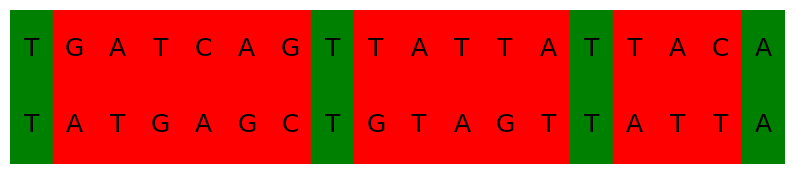

TAACAGATCGAAATTTTA
TACTTACTGATCGAAATT
['Stop', 'Gln', 'Ile', 'Glu', 'Ile', 'Leu']
['Tyr', 'Leu', 'Leu', 'Ile', 'Glu', 'Ile']


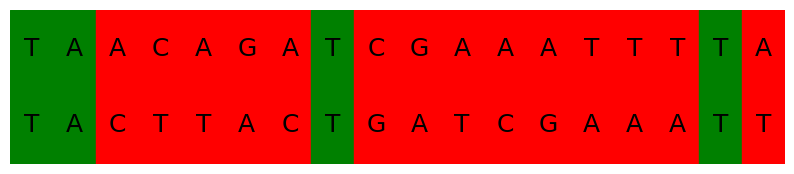

TTATATTTTATATTAGGA
CTCTATATTTTATATTTG
['Leu', 'Tyr', 'Phe', 'Ile', 'Leu', 'Gly']
['Leu', 'Tyr', 'Ile', 'Leu', 'Tyr', 'Leu']


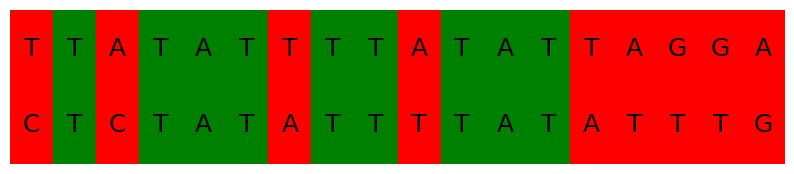

CTGCAGTATTATTATTAT
CAGCCTTATTATTACTTT
['Leu', 'Gln', 'Tyr', 'Tyr', 'Tyr', 'Tyr']
['Gln', 'Pro', 'Tyr', 'Tyr', 'Tyr', 'Phe']


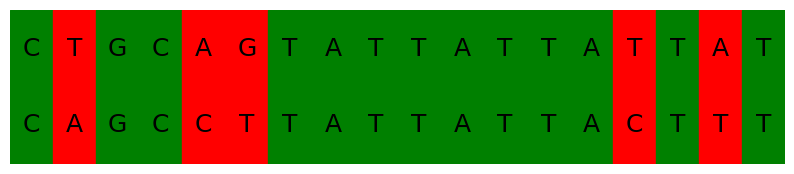

AGCTTGATCCGGTATAGT
GAGCTTGAGCAGGAATAG
['Ser', 'Leu', 'Ile', 'Arg', 'Tyr', 'Ser']
['Glu', 'Leu', 'Glu', 'Gln', 'Glu', 'Stop']


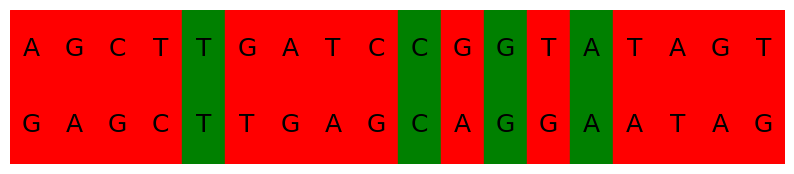

TTTTGACTTTTACCACCA
GATTTTGATTATTACCCC
['Phe', 'Stop', 'Leu', 'Leu', 'Pro', 'Pro']
['Asp', 'Phe', 'Asp', 'Tyr', 'Tyr', 'Pro']


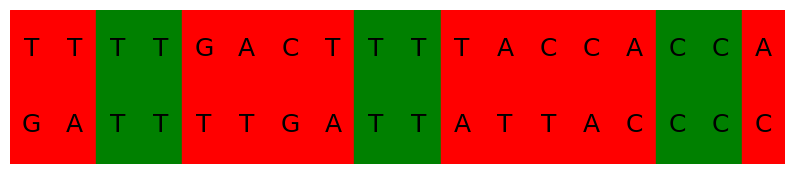

TGCTCATGCTTTTATTAT
CTGCTCATGCTTTTGTTA
['Cys', 'Ser', 'Cys', 'Phe', 'Tyr', 'Tyr']
['Leu', 'Leu', 'Met', 'Leu', 'Leu', 'Leu']


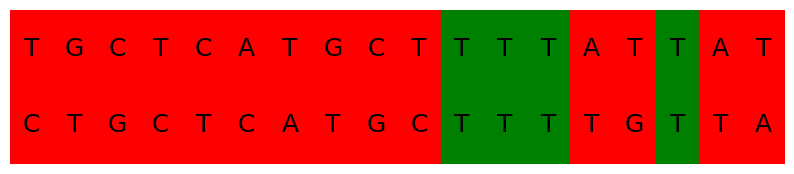

GTAGATTTAGCAATTTTT
TTGATTTAGCAATTTTTT
['Val', 'Asp', 'Leu', 'Ala', 'Ile', 'Phe']
['Leu', 'Ile', 'Stop', 'Gln', 'Phe', 'Phe']


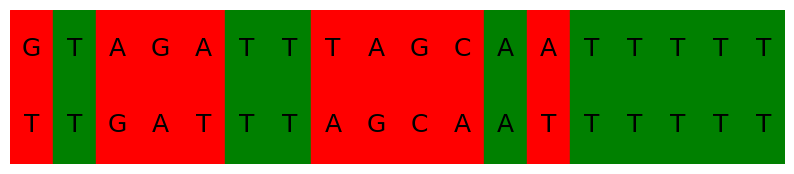

TTGTAACTGCTCATGCTT
TTTATAATGTAATTGTTA
['Leu', 'Stop', 'Leu', 'Leu', 'Met', 'Leu']
['Phe', 'Ile', 'Met', 'Stop', 'Leu', 'Leu']


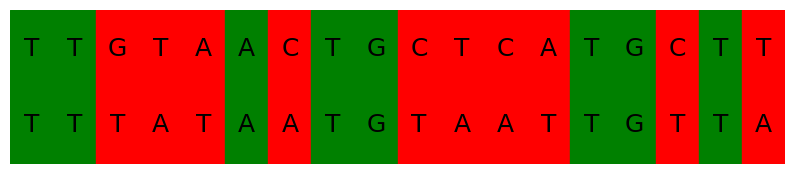

AATTATTAATATACGATC
CAGTAATTAATATACGAT
['Asn', 'Tyr', 'Stop', 'Tyr', 'Thr', 'Ile']
['Gln', 'Stop', 'Leu', 'Ile', 'Tyr', 'Asp']


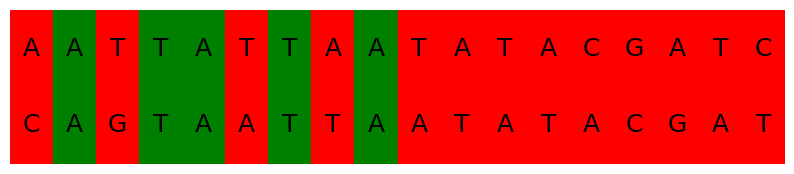

In [93]:
# 2
# 3

prototype_class_index = 17

for i in range(PROTOTYPE_COUNT):
    string = decode_onehot(input_tensor[0].numpy(), three_dim=True)

    # print(string[best_prototypes[9][i]*18:(best_prototypes[9][i]+1)*18])
    # print("")

    # Draw 18 squares each with one character of prot using matplotlib
    prot = prot_strings[prototype_class_index][int(best_prototypes[prototype_class_index][i])]
    corresponding = string[best_prototypes[prototype_class_index][i]*18:(best_prototypes[prototype_class_index][i]+1)*18]

    # This only works since prototypes are length 0 mod 3
    prot_amino = create_amino(prot)
    string_amino = create_amino(corresponding)
    print(prot_amino)
    print(string_amino)

    for i, c in enumerate(prot):
        plt.text(.05 * i+.05, 0.5, c, fontsize=18, ha='center', va='center')
        plt.text(.05 * i+.05, 0.4, corresponding[i], fontsize=18, ha='center', va='center')
        # Color the squares based on whether the character matches the prototype
        if c == corresponding[i]:
            plt.gca().add_patch(plt.Rectangle((.05 * i+.025, 0.35), .05, .2, fill=True, color='green'))
        else:
            plt.gca().add_patch(plt.Rectangle((.05 * i+.025, 0.35), .05, .2, fill=True, color='red'))

    # Resize plot image
    plt.gcf().set_size_inches(10, 2)
    plt.ylim(.35, .55)
    plt.xlim(.025, .925)

    # Hide plot axis
    plt.axis('off')
    plt.show()

In [94]:
is_best_prototype_location = torch.zeros(CLASS_COUNT, 40*18)

for i in range(CLASS_COUNT):
    best_prototypes_for_class = best_prototypes[i]

    for ind, j in enumerate(best_prototypes_for_class):
        # is_best_prototype_location[i][j*18:(j+1)*18] = (10 - ind) / 10
        is_best_prototype_location[i][j*18:(j+1)*18] = 1

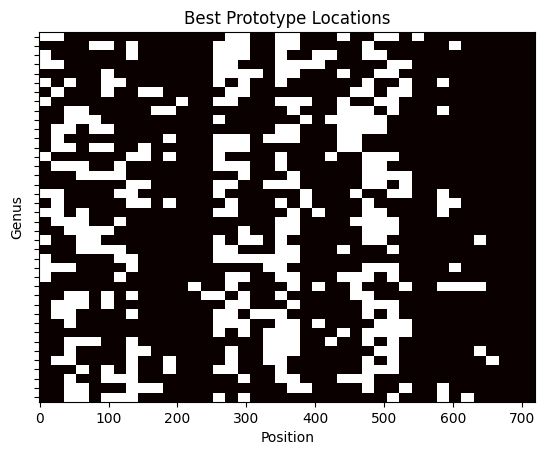

In [95]:
# Draw the heatmap
import matplotlib.pyplot as plt

classes = train_dataset.get_classes(TAXONOMY_NAME)[0]

plt.imshow(is_best_prototype_location, cmap='hot', interpolation='nearest')
plt.title("Best Prototype Locations")
plt.ylabel(TAXONOMY_NAME.capitalize())
plt.xlabel("Position")

# Set the y axis labels to the class names, make them diagonal
plt.yticks(range(CLASS_COUNT), classes)
# Decrease the y axis label font size
plt.yticks(fontsize=6)

# Make its aspect ratio 2:1
plt.gca().set_aspect('auto', adjustable='box',)
# plt.gca().set_aspect(10)
